### 决策树的基本原理   
决策树类似于提问题回答过程。根据特征数据，进行合理的选择划分。  
在决策的过程，不同的特征选择不同的路径，最后会输出一个决策值。

### 信息增益和熵
香农熵的计算方法 $H = - \sum_{i=1}^{n} p(x_i)\log_2 p(x_i) $  
其中 $p(x_i)$为某一种数据发生的概率。  
在带有标签的数据集中，其体现为某个标签出现的次数除以整个数据集的大小。  
熵的数值可以体现数据的分散程度，如果熵为0，表示整个数据集属于一类。熵越大，表示混合的数据越多。

熵越大，随机变量的不确定性就越大。从定义可以验证:
$$0\leq H(P) \leq \log n$$
当随机变量只取两个值，例如1，0时，即X的分布为:
$$P(X=1)=p, P(X=0)=1-p, 0\leq p \leq 1$$
熵为:
$$H(p)=-p \log_2 p - (1-p)\log_2 (1-p)$$
这时，熵$H(P)$随概率$p$变化的曲线如下图所示:

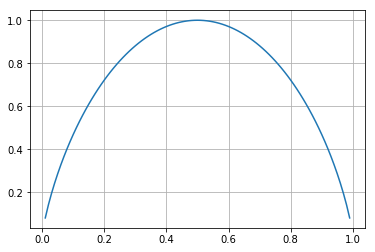

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

p = np.arange(0.01, 1, 0.01)
plt.figure()
plt.plot(p, (-p*np.log2(p)) - ((1-p)*np.log2(1-p)))
plt.grid()
plt.show()

当$p=0$或$p=1$时$H(p)=0$,随机变量完全没有不确定性。 当$p=0.5$时，$H(p)=1$，熵取值最大，随机变量的不确定性最大。

we will follow the **[ID3](http://en.wikipedia.org/wiki/ID3_algorithm)** algorithm, which tells us how to split the data and when to stop splitting it.


###  Function to calculate the Shannon entropy of a dataset

In [2]:
from math import log


#计算给定数据集的香农熵
#函数的输入是一个带标签的数据集
def calcShannonEnt(dataSet):
    #得到数据的长度
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        #获取当前数据的标签
        currentLabel = featVec[-1]
        # 如果当前数据的标签没有在标签列表里，则初始化标签数据
        #  此时的key是当前的标签数据
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        #将当前的标签计数加1
        labelCounts[currentLabel] += 1
    #初始化香农熵为0
    shannonEnt = 0.0
    # 对标签进行索引
    for key in labelCounts:
        # prob = 标签的个数/ 数据集的大小
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

In [3]:
# 创建数据集
def createDataSet():
    dataSet = [[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels

In [4]:
# 测试数据集
myDat, labels = createDataSet()
print(calcShannonEnt(myDat))

0.9709505944546686


`The higher the entropy, the more mixed up the data is.`

In [5]:
myDat[0][-1] = 'maybe'
print(myDat)
print(calcShannonEnt(myDat))

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
1.3709505944546687


## Dataset splitting on a given feature

In [6]:
# 输入分别为，带划分的数据集，划分数据集的特征索引，划分数据的特征值。
# 返回的是 按照指定特征值来划分数据的子集
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    # 索引数据集中的数据
    for featVec in dataSet:
        # 判断，第axis维数据的值是否为value
        if featVec[axis] == value:
            # 去除当前axis的数据，取其他数据组成的子集
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis + 1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [7]:
# 测试
myDat, labels = createDataSet()
print(myDat)
print("inputs myDat,0,1")
# 按照第0个特征，数值为1划分时候的子集。
# 返回值时第0个特征数值为1的时候的子集
print(splitDataSet(myDat, 0, 1))
print("inputs myDat,0,0")
# 返回第0个特征数值为0的子集
print(splitDataSet(myDat, 0, 0))

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
inputs myDat,0,1
[[1, 'yes'], [1, 'yes'], [0, 'no']]
inputs myDat,0,0
[[1, 'no'], [1, 'no']]


### Choosing the best feature to split on

In [8]:
# 数据的输入是数据集，包含N个特征，最后一列是标签
def chooseBestFeatureToSplit(dataSet):
    # 获取特征的数量
    numFeatures = len(dataSet[0]) - 1
    # 获取当前数据集的香农熵，此数据代表数据的分散程度。
    baseEntropy = calcShannonEnt(dataSet)
    # 香浓增益，和最好特性初值。
    bestInfoGain = 0.0
    bestFeature = -1
    # 取数据集中的每个特征
    for i in range(numFeatures):
        # 获取只包含当前特征的数据集
        featList = [example[i] for example in dataSet]
        # 返回无序去除重复值的列表
        uniqueVals = set(featList)

        newEntropy = 0.0
        # 依次获取当前特性的可取的数值
        for value in uniqueVals:
            # 包含当前特性数据的子集，注意子集会去除当前特性。
            subDataSet = splitDataSet(dataSet, i, value)
            # 计算子集的香浓增益
            prob = len(subDataSet) / float(len(dataSet))
            # 求取香浓增益的和
            newEntropy += prob * calcShannonEnt(subDataSet)
        # 计算信息增益
        infoGain = baseEntropy - newEntropy
        # 替换最好的特性
        if (infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

In [9]:
# 测试函数。 次函数的返回值为0，说明在当前的数据集情况下，
# 最好的分类方式是按照第0个特性进行划分。
myDat, labels = createDataSet()
print(myDat)
print(chooseBestFeatureToSplit(myDat))

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
0


### Recursively building the tree

In [10]:
# return the most frequency item
import operator


def majorityCnt(ClassList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(
        classCount.items, key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

## Tree-building code

In [11]:
def createTree(dataSet, labels):  #dataSet为数据集，labels为每个特征的标签
    # 得到标签的集合，即最后一列的结果，yes or no
    classList = [example[-1] for example in dataSet]

    # 递归结束的条件。如果所有的标签都是一样的，则没有必要进行分类。
    if classList.count(classList[0]) == len(classList):
        #直接返回标签
        return classList[0]

    # 递归结束的条件， 如果数据集的长度为1，说明只剩下标签数据了，结束递归函数。
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)

    # 获得一个划分效果最好的特性的index
    bestFeat = chooseBestFeatureToSplit(dataSet)
    # 获取特征值的名字。
    bestFeatLabel = labels[bestFeat]
    # 输出字典
    myTree = {bestFeatLabel: {}}
    # 将输出的标签删除
    del (labels[bestFeat])
    # 获得刚选择的特征值的元素集合
    featValues = [example[bestFeat] for example in dataSet]
    # 去除重复值
    uniqueVals = set(featValues)

    for value in uniqueVals:
        subLabels = labels[:]
        # myTree[bestFeatLabel] can get the value to the key
        myTree[bestFeatLabel][value] = createTree(
            splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

In [12]:
myDat, labels = createDataSet()
myTree = createTree(myDat, labels)
print(myTree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


## Plotting trees in Python with Matplotlib annotations
### Matplotlib annotations
- Plotting tree nodes with text annotations

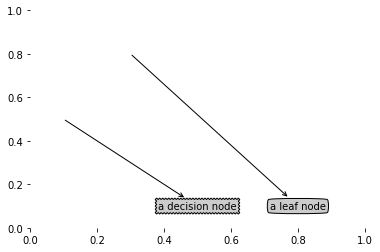

In [13]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle='sawtooth', fc='0.8')
leafNode = dict(boxstyle="round4", fc='0.8')
arrow_args = dict(arrowstyle="<-")


def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(
        nodeTxt,
        xy=parentPt,
        xycoords="axes fraction",
        xytext=centerPt,
        textcoords="axes fraction",
        va='center',
        ha='center',
        bbox=nodeType,
        arrowprops=arrow_args)


def createPlot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon=False)
    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()


createPlot()

### Constructing a tree of annotations 
- Identifying the number of leaves in a tree and the depth

In [14]:
# get the number of the leafs of the tree(leafs don't have children)
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            # if the value is a dictionary
            numLeafs += getNumLeafs(secondDict[key])
        else:  # else it is a leaf
            numLeafs += 1
    return numLeafs

In [15]:
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

In [16]:
def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers':{0: 'no', 1: 'yes'}}}},\
                  {'no surfacing': {0: 'no', 1: {'flippers':{0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

myTree = retrieveTree(0)
print(myTree)
print('the num of the leafs is ', getNumLeafs(myTree))
print('the depth of the tree is ',getTreeDepth(myTree))

In [17]:
myTree = retrieveTree(1)
print(myTree)
print('the num of the leafs is ', getNumLeafs(myTree))
print('the depth of the tree is ', getTreeDepth(myTree))

{'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
the num of the leafs is  4
the depth of the tree is  3


**The plotTree function**

In [18]:
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

In [19]:
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW,\
                           plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt,
                     leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD

In [20]:
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

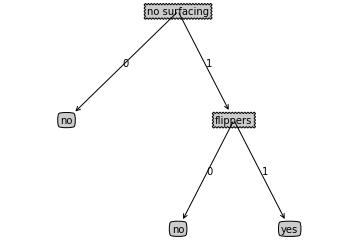

In [21]:
myTree = retrieveTree(0)
createPlot(myTree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}, 3: 'maybe'}}


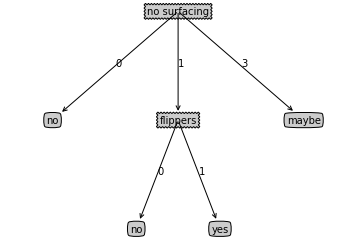

In [22]:
myTree['no surfacing'][3] = 'maybe'
print(myTree)
createPlot(myTree)

## Testing and storing the classifier
### Test: using the tree for classification
- Classification function for an existing decision tree

In [23]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)

    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [24]:
myDat, labels = createDataSet()
print('labels', labels)
myTree = retrieveTree(0)
print('myTree', myTree)
print(classify(myTree, labels, [1, 0]))
print(classify(myTree, labels, [1, 1]))

labels ['no surfacing', 'flippers']
myTree {'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
no
yes


### Use: persisting the decision tree
- Methods for persisting the decision tree with pickle 

In [25]:
def storeTree(inputTree, filename):
    import pickle
    fw = open(filename, 'wb')
    pickle.dump(inputTree, fw)
    fw.close()

In [26]:
def grabTree(filename):
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)

In [27]:
storeTree(myTree, './classifierStorage.txt')
print(grabTree('./classifierStorage.txt'))

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


## Example: using decision trees to predict contact lens type 

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}}, 'pre': 'soft', 'young': 'soft'}}, 'yes': {'prescript': {'hyper': {'age': {'presbyopic': 'no lenses', 'pre': 'no lenses', 'young': 'hard'}}, 'myope': 'hard'}}}}, 'reduced': 'no lenses'}}


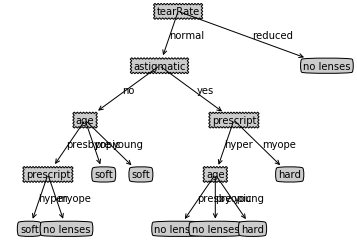

In [28]:
fr = open('./lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels=['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)
print(lensesTree)
createPlot(lensesTree)